In [3]:
#!/usr/bin/env python
# coding: utf-8
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import defaultdict
from CarDataset import CarDataset
from cnn6 import ConvNet

plt.ion()   # interactive mode
# 학습을 위한 데이터 증가(Augmentation)와 일반화하기
# 단지 검증을 위한 일반화하기 // transform을 통해서 PIL image로 변환해줌

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#transfer_test.py랑 carDataset.py는 같은 폴더에 저장
#해당 폴더 안에 data 폴더 위치시켜야 됨
train_dataset = CarDataset('data/cars/anno_train.csv', 'data/cars/train/', transform=data_transforms['train'])

train_dataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

val_dataset = CarDataset('data/cars/anno_test.csv', 'data/cars/test/', transform=data_transforms['val'])

val_dataLoader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

dataloaders = {}
dataloaders['train'] = train_dataLoader
dataloaders['val'] = val_dataLoader

#dataset_sizes['train'] = train set 사진 갯수
#dataset_sizes['val'] = val set 사진 갯수
dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['val'] = len(val_dataset)

cuda:0
(906, 1810, 3)


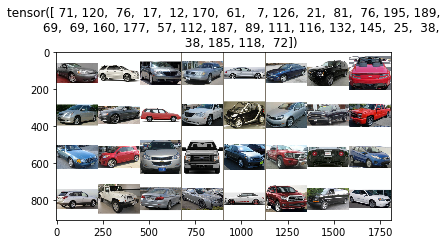

In [4]:
#classes가 하위 폴더명을 가져오는 
#class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#GPU가 이용 가능한지를 확인

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) #inp,mean,std가 의미하는게 뭐지?
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean   # 정규화를 해제
    inp = np.clip(inp, 0, 1) # 값들의 범위를 제약 inp는 0과 1사이의 값으로 표현된다.
    print(inp.shape)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 4로 했으니 사진 4장이 로드된다.
inputs, classes = next(iter(dataloaders['train']))

# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
out = torchvision.utils.make_grid(inputs)
#--
# 이미지를 출력한다.
imshow(out, str(classes))


In [ ]:
num_classes = 196
#vgg
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
vgg_model = vgg_model.to(device)

#resnet
model_ft = models.resnet50(pretrained=True) 
num_ftrs = model_ft.fc.in_features 
print(num_ftrs)
model_ft.fc = nn.Linear(num_ftrs, num_classes)  # Pre-trained model의 끝단에 fully-connected layer 추가 class가 196개 이므로 196
model_ft = model_ft.to(device)

#cnn
cnn_model = ConvNet(num_classes).to(device)


#------손실함수/optimizer
criterion = nn.CrossEntropyLoss() #loss 함수로 cross entropy

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # optimizer로 SGD사용
optimizer_vgg = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)
optimizer_cnn = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
#SGD를 사용하면 Gradient Descent와 비교했을때 두가지의 장점 존재
#mini_batch에 대해서만 loss값 계산
#안정적 weight update가능 momentum개념으로
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)
exp_lr_scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

In [ ]:
#---------trainingset && testSet검사
def train_model(model1, model2, model3, criterion, optimizer1, optimizer2, 
                optimizer3, scheduler1, scheduler2, scheduler3,num_epochs=25):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)
    record = defaultdict(list) #epoch 마다 train loss, accuracy, test loss, accuracy 저장
    best_model_wts1 = copy.deepcopy(model1.state_dict()) # model의 매개변수들을 불러온다.
    best_model_wts2 = copy.deepcopy(model2.state_dict())
    best_model_wts3 = copy.deepcopy(model3.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트
        print('-' * 10)
    
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                scheduler1.step()
                scheduler2.step()
                scheduler3.step()
                model1.train()  # Set model to training mode
                model2.train()
                model3.train()
            else:
                model1.eval()   # Set model to evaluate mode
                model2.eval()
                model3.eval()
            
            running_loss = 0.0
            running_corrects = 0
            count = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]: #dataloader로부터 dataset과 그에 해당되는 label을 불러옴
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림
                #print(inputs.shape)
                # zero the parameter gradients
                optimizer1.zero_grad() #Gradient를 0으로 초기화
                optimizer2.zero_grad() #Gradient를 0으로 초기화
                optimizer3.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    model1_outputs = model1(inputs)
                    model2_outputs = model2(inputs)
                    model3_outputs = model3(inputs)
                    outputs = model1_outputs * 0.3 + model2_outputs * 0.3 + model3_outputs * 0.4
                    #여기서 이제 3개의 모델을 합친 하나의 결과를 내놓는다.
                    _, preds = torch.max(outputs, 1) #마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    _, preds_resnet = torch.max(model1_outputs, 1)
                    _, preds_vgg = torch.max(model2_outputs, 1)
                    _, preds_cnn = torch.max(model3_outputs, 1)
                    
                    loss = criterion(outputs, labels)
                    loss1 = criterion(model1_outputs, labels)
                    loss2 = criterion(model2_outputs, labels)
                    loss3 = criterion(model3_outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss1.backward() #backward
                        loss2.backward()
                        loss3.backward()
                        optimizer1.step()
                        optimizer2.step()
                        optimizer3.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if count%50 == 0:
                    print('{}, {:.4f}, {}, {}'.format(count, loss, running_corrects, 32 * (count + 1)))
                count+=1
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            record[phase + '_loss'].append(epoch_loss)
            record[phase + '_acc'].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts1 = copy.deepcopy(model1.state_dict())
                best_model_wts2 = copy.deepcopy(model2.state_dict())
                best_model_wts3 = copy.deepcopy(model3.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model1.load_state_dict(best_model_wts1)
    model2.load_state_dict(best_model_wts2)
    model3.load_state_dict(best_model_wts3)
    models = model1, model2, model3
    return (models, record)

In [ ]:
def draw_plot(train_loss, train_acc, val_loss, val_acc):
    fig = plt.figure()
    loss_ax = fig.add_subplot(2, 1, 1)
    acc_ax = fig.add_subplot(2, 1, 2)
    
    x = np.arange(len(train_loss))
    loss_ax.set_title('Loss per epoch')
    loss_ax.plot(x, train_loss, label='train loss')
    loss_ax.plot(x, val_loss, label='val loss', color='orange')
    loss_ax.set_xlabel("epochs")
    loss_ax.set_ylabel("loss")
    loss_ax.legend(loc="upper right")
    
    acc_ax.set_title('Accuracy per epoch')
    acc_ax.set_ylim(0, 1.0)
    acc_ax.plot(x, train_acc, label='train acc')
    acc_ax.plot(x, val_acc, label='val acc', color='orange')
    acc_ax.set_xlabel("epochs")
    acc_ax.set_ylabel("accuracy")
    acc_ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [ ]:
#------ 모델
proposing_models, record = train_model(model_ft, vgg_model, cnn_model, criterion, optimizer_ft, optimizer_vgg, optimizer_cnn, exp_lr_scheduler, exp_lr_scheduler_vgg, exp_lr_scheduler_cnn, num_epochs=25)
#vgg_model = train_model(vgg_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
PATH = "newModel.pt"
torch.save(proposing_models,PATH)